# Airline Review Comparison – Social Media Analytics Project

## Webscraping Skytrax Airline reviews

#### This Jupyter notebook includes some code to get you started with web scraping. I used a package called BeautifulSoup to collect the data from the web. Once I collected the data and saved it into a local .xlsx file I started analying the data.

#### Scraping data from Skytrax
#### The website [https://www.airlinequality.com] was the base url used to extract all the data for the analysis implimented in this webscraping exercise. For this task, we collected reviews for 5 airlines:

- TAP Air Portugal

- British Airways

- Iberia

- Lufthansa

- Air France

##  Imports all necessary Python libraries for web scraping (like BeautifulSoup and Selenium), data handling (Pandas), and networking (urllib).

In [1]:
# Load Libraries

import numpy as np
import pandas as pd
from urllib.request import urlopen
import bs4
from bs4 import BeautifulSoup
import ssl
from selenium import webdriver
from selenium.webdriver.firefox.firefox_binary import FirefoxBinary
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.common.by import By
import time
import datetime
from datetime import timedelta
from datetime import datetime
import re
import requests, re
from requests.exceptions import RequestException
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import urllib.request  
from socket import gaierror
import time
import json

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Allow not verified SSL (Secure Socket Layer) certificates to be opened
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# Load the list of the Airlines to read the content
AirlinesToscrap = pd.read_excel("AirlinesToscrap.xlsx", sheet_name="Sheet1", index_col="ID", engine='openpyxl')

In [4]:
AirlinesToscrap.head()

,URL
ID,
Tap_Portugal,https://www.airlinequality.com/airline-reviews...
British_airways,https://www.airlinequality.com/airline-reviews...
Iberia,https://www.airlinequality.com/airline-reviews...
Lufthansa,https://www.airlinequality.com/airline-reviews...
Air_France,https://www.airlinequality.com/airline-reviews...


In [5]:
# Defines the target URLs for scraping.

base_urls = [
    "https://www.airlinequality.com/airline-reviews/tap-portugal",
    "https://www.airlinequality.com/airline-reviews/british-airways",
    "https://www.airlinequality.com/airline-reviews/iberia",
    "https://www.airlinequality.com/airline-reviews/lufthansa",
    "https://www.airlinequality.com/airline-reviews/air-france"
]

for url in base_urls:
    req = urllib.request.Request(
        url, 
        data=None, 
        headers={
            'User-Agent': 'https://developers.whatismybrowser.com/useragents/parse/1274624safari-macos-webkit'
        }
    )
    page = urllib.request.urlopen(req, timeout=60)

In [6]:
# Reads the raw HTML content and decode it to the UTF-8 encoding as a string
html = page.read().decode("utf-8")  # Can generate errors if time-out

# For more information about encoding visit https://www.w3.org/International/questions/qa-what-is-encoding

In [7]:
# Parse the html into a beatuful soup object
soup = BeautifulSoup(html, "html.parser")

In [8]:
# What about the rating?

# Let's divide the problem into parts
r = soup.select("div[class*=rating-10]")
r

[<div class="rating-10 rating-large">
 <span itemprop="ratingValue">
 												5</span>/<span itemprop="bestRating">10</span> </div>,
 <div class="rating-10" itemprop="reviewRating" itemscope="" itemtype="http://schema.org/Rating">
 <span itemprop="ratingValue">10</span>/<span itemprop="bestRating">10</span>
 </div>,
 <div class="rating-10" itemprop="reviewRating" itemscope="" itemtype="http://schema.org/Rating">
 <span itemprop="ratingValue">1</span>/<span itemprop="bestRating">10</span>
 </div>,
 <div class="rating-10" itemprop="reviewRating" itemscope="" itemtype="http://schema.org/Rating">
 <span itemprop="ratingValue">9</span>/<span itemprop="bestRating">10</span>
 </div>,
 <div class="rating-10" itemprop="reviewRating" itemscope="" itemtype="http://schema.org/Rating">
 <span itemprop="ratingValue">1</span>/<span itemprop="bestRating">10</span>
 </div>,
 <div class="rating-10" itemprop="reviewRating" itemscope="" itemtype="http://schema.org/Rating">
 <span itemprop="ratingValue

In [9]:
# Strip just the rating from attribute
rating_div = r[0]
rating_value = rating_div.find("span", itemprop="ratingValue").get_text(strip=True)
best_rating = rating_div.find("span", itemprop="bestRating").get_text(strip=True)
rating = f"{rating_value}/{best_rating}"
print(rating)

5/10


In [10]:
# Get just the rated value
rating_div = r[0]
rating_value = int(rating_div.find("span", itemprop="ratingValue").get_text(strip=True))
print(rating_value)

5


In [11]:
# Get just the review?
q = soup.find_all("div", {"class": "text_content"})[0]
q

<div class="text_content" itemprop="reviewBody">✅ <strong><a href="https://www.airlinequality.com/verified-reviews/"><em>Trip Verified</em></a></strong> |   Amazing journey with Air France. The aircraft was new and the seat offered both privacy and comfort. The crew has been attentive and caring. Free wifi for texting is an advantage as well.</div>

In [12]:
# Remove the tags and get just the review text
q.get_text()

'✅ Trip Verified |   Amazing journey with Air France. The aircraft was new and the seat offered both privacy and comfort. The crew has been attentive and caring. Free wifi for texting is an advantage as well.'

In [13]:
# Process each url page and scrap the reviews, ratings, reviewer and apply sentiment analysis on the reviews

base_urls = [
    ("Tap Portugal", "https://www.airlinequality.com/airline-reviews/tap-portugal"),
    ("British Airways", "https://www.airlinequality.com/airline-reviews/british-airways"),
    ("Iberia", "https://www.airlinequality.com/airline-reviews/iberia"),
    ("Lufthansa", "https://www.airlinequality.com/airline-reviews/lufthansa"),
    ("Air France", "https://www.airlinequality.com/airline-reviews/air-france")
]

reviews_by_airline = {}  # Dictionary to store reviews by airline
max_reviews_per_url = 100   # Maximum number of reviews to collect per URL
pages = 50  # Number of pages to scrape per URL

for airline, base_url in base_urls:
    reviews = []  # List to store reviews for each airline
    review_count = 0  # Initialize review count

    for i in range(1, pages + 1):
        print(f"Scraping page {i}")

        # Create URL to collect links from paginated data
        url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={max_reviews_per_url}"

        # Collect HTML data from this page
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")

        # Find review elements on the page
        review_elements = soup.find_all("article", {"itemtype": "http://schema.org/Review"})

        for element in review_elements:
            # rating
            rating_div = element.find("div", {"class": "rating-10"})
            rating_value = rating_div.find("span", itemprop="ratingValue").get_text(strip=True)
            best_rating = rating_div.find("span", itemprop="bestRating").get_text(strip=True)
            rating = f"{rating_value}/{best_rating}"
            rating_value = int(rating_value)

            # user
            reviewer = element.find("span", itemprop="name").get_text(strip=True)

            # text
            reviewText = element.find("div", {"class": "text_content"}).get_text(strip=True)

            # Store the review in the list
            reviews.append({
                'Airline': airline,
                'Rating': rating,
                'Reviewer': reviewer,
                'ReviewText': reviewText
            })

            review_count += 1
            if review_count >= max_reviews_per_url:
                break

        if review_count >= max_reviews_per_url:
            break

    # Store the reviews in the dictionary
    reviews_by_airline[airline] = reviews

# Perform sentiment analysis for each airline
sentiments = []

for airline, reviews in reviews_by_airline.items():
    for review in reviews:
        blob = TextBlob(review['ReviewText'])
        sentiment = blob.sentiment.polarity
        sentiments.append({
            'Airline': review['Airline'],
            'Rating': review['Rating'],
            'Reviewer': review['Reviewer'],
            'ReviewText': review['ReviewText'],
            'Sentiment': sentiment
        })

# Create a DataFrame from the sentiments
df = pd.DataFrame(sentiments)
# Example usage: Access the sentiment analysis results for a specific airline
tap_sentiments = df[df['Airline'] == 'Tap Portugal']
british_sentiments = df[df['Airline'] == 'British Airways']
iberia_sentiments = df[df['Airline'] == 'Iberia']
lufthansa_sentiments = df[df['Airline'] == 'Lufthansa']
france_sentiments = df[df['Airline'] == 'Air France']
print(tap_sentiments)
print(british_sentiments)
print(iberia_sentiments)
print(lufthansa_sentiments)
print(france_sentiments)


Scraping page 1
Scraping page 1
Scraping page 1
Scraping page 1
Scraping page 1
         Airline Rating          Reviewer  \
0   Tap Portugal   2/10         C Johnson   
1   Tap Portugal   3/10          K Gorsen   
2   Tap Portugal   8/10    Andreas Becker   
3   Tap Portugal   2/10  Alexandre Areias   
4   Tap Portugal   1/10       N Gayasenko   
..           ...    ...               ...   
95  Tap Portugal   3/10    Patrícia Rojas   
96  Tap Portugal   3/10        Alex Makai   
97  Tap Portugal   1/10     Thiago Lamelo   
98  Tap Portugal  10/10     Diogo Freitas   
99  Tap Portugal   1/10         M Delissi   

                                           ReviewText  Sentiment  
0   ✅Trip Verified| I had a really unpleasant expe...   0.068750  
1   ✅Trip Verified|   For a flag carrier like TAP,...   0.133259  
2   ✅Trip Verified|   Flights taken in business cl...   0.189404  
3   Not Verified|  Terrible customer service, very...  -0.271419  
4   ✅Trip Verified|   They should be ashamed

In [14]:
df

,Airline,Rating,Reviewer,ReviewText,Sentiment
0,Tap Portugal,2/10,C Johnson,✅Trip Verified| I had a really unpleasant expe...,0.068750
1,Tap Portugal,3/10,K Gorsen,"✅Trip Verified| For a flag carrier like TAP,...",0.133259
2,Tap Portugal,8/10,Andreas Becker,✅Trip Verified| Flights taken in business cl...,0.189404
3,Tap Portugal,2/10,Alexandre Areias,"Not Verified| Terrible customer service, very...",-0.271419
4,Tap Portugal,1/10,N Gayasenko,✅Trip Verified| They should be ashamed of th...,-0.042857
...,...,...,...,...,...
495,Air France,2/10,Jen Smyne,Not Verified| They charged for our underseat...,0.031061
496,Air France,1/10,A Rossi,✅Trip Verified| Not great staff or service com...,-0.378030
497,Air France,5/10,Lesley Waring,Not Verified| Boarded the plane at about 10.45...,-0.120000
498,Air France,7/10,G Johnson,✅Trip Verified| Air France was a step above th...,0.136218


In [15]:
# Apply Data filtering
def filtering_text(data):
    clean_list = []
    for text in data:
        clean = re.sub(r'✅ Trip Verified | ', ' ', text, flags=re.MULTILINE)
        clean = re.sub(r'Not Verified | ', ' ', clean)
        clean = re.sub(r'[^\x00-\x7f]', r'', clean)
        clean = re.sub(r'(\\u[0-9A-Fa-f]+)', r'', clean)
        clean = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", clean)
        clean = re.sub(r'\\u\w\w\w\w', '', clean)
        clean = re.sub(r"[.,:;+!\-_<^/=?\"'\(\)\d\*]", " ", clean)
        clean = clean.strip()
        clean_list.append(clean)
        
    return clean_list

In [16]:
# Setting up the stop-words 
stop_words = stopwords.words("english")

In [17]:
import spacy
spacy.cli.download("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [18]:
nlp = spacy.load("en_core_web_sm")

In [19]:
def lemmatization_text(text): # text
    rev_text = nlp(text)
    # Extract lemmatized words in lower case format if not digits, not punctuation, not stopword, and length not less than 2
    rev_text = ([token.lemma_.lower() for token in rev_text if not token.is_stop and token.text not in stop_words and not token.is_punct and len(token.text) > 3])
    
    return rev_text

In [20]:
# Get the negative, positive and neutral sentiment
def get_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    if sentiment > 0:
        return 'positive'
    elif sentiment < 0:
        return 'negative'
    else:
        return 'neutral'

In [21]:
# Applying the function on the reviews 
df["sentiment"] = df["ReviewText"].apply(get_sentiment)
df["clean_reviews"] = filtering_text(df["ReviewText"])
df["clean_reviews"] = df["clean_reviews"].apply(lemmatization_text)
df

,Airline,Rating,Reviewer,ReviewText,Sentiment,sentiment,clean_reviews
0,Tap Portugal,2/10,C Johnson,✅Trip Verified| I had a really unpleasant expe...,0.068750,positive,"[trip, verified, unpleasant, experience, airli..."
1,Tap Portugal,3/10,K Gorsen,"✅Trip Verified| For a flag carrier like TAP,...",0.133259,positive,"[trip, verified, flag, carrier, like, give, co..."
2,Tap Portugal,8/10,Andreas Becker,✅Trip Verified| Flights taken in business cl...,0.189404,positive,"[trip, verified, flights, take, business, clas..."
3,Tap Portugal,2/10,Alexandre Areias,"Not Verified| Terrible customer service, very...",-0.271419,negative,"[verify, terrible, customer, service, disorgan..."
4,Tap Portugal,1/10,N Gayasenko,✅Trip Verified| They should be ashamed of th...,-0.042857,negative,"[trip, verified, ashamed, practice, airline, e..."
...,...,...,...,...,...,...,...
495,Air France,2/10,Jen Smyne,Not Verified| They charged for our underseat...,0.031061,positive,"[verify, charge, underseat, state, home, line,..."
496,Air France,1/10,A Rossi,✅Trip Verified| Not great staff or service com...,-0.378030,negative,"[trip, verified, great, staff, service, compar..."
497,Air France,5/10,Lesley Waring,Not Verified| Boarded the plane at about 10.45...,-0.120000,negative,"[verify, boarded, plane, , buenos, aires,..."
498,Air France,7/10,G Johnson,✅Trip Verified| Air France was a step above th...,0.136218,positive,"[trip, verified, france, step, competitor, rou..."


In [22]:
# Extract and save on an excel file
df.to_excel("ExtractedAirlines2.xlsx")

# Text Data Analysis

In [23]:
# Filter the DataFrame for Tap Portugal
tap_reviews = [word for data in df[df['Airline'] == 'Tap Portugal']["ReviewText"] for word in data]

# Compute the frequency distribution for Tap Portugal
tap_fqdist = FreqDist(tap_reviews)

# Get the most common words and their frequencies for Tap Portugal
tap_most_common = tap_fqdist.most_common(10)

# Print the most common words and their frequencies for Tap Portugal
print("Most common words for Tap Portugal:")
print(tap_most_common)
print()

# Filter the DataFrame for British Airways
british_reviews = [word for data in df[df['Airline'] == 'British Airways']["ReviewText"] for word in data]

# Compute the frequency distribution for British Airways
british_fqdist = FreqDist(british_reviews)

# Get the most common words and their frequencies for British Airways
british_most_common = british_fqdist.most_common(10)

# Print the most common words and their frequencies for British Airways
print("Most common words for British Airways:")
print(british_most_common)


# Filter the DataFrame for Iberia
iberia_reviews = [word for data in df[df['Airline'] == 'Iberia']["ReviewText"] for word in data]

# Compute the frequency distribution for iberia
iberia_fqdist = FreqDist(iberia_reviews)

# Get the most common words and their frequencies for iberia
iberia_most_common = iberia_fqdist.most_common(10)

# Print the most common words and their frequencies for iberia
print("Most common words for Iberia:")
print(iberia_most_common)


# Filter the DataFrame for lufthansa
lufthansa_reviews = [word for data in df[df['Airline'] == 'Lufthansa']["ReviewText"] for word in data]

# Compute the frequency distribution for lufthansa
lufthansa_fqdist = FreqDist(lufthansa_reviews)

# Get the most common words and their frequencies for lufthansa
lufthansa_most_common = lufthansa_fqdist.most_common(10)

# Print the most common words and their frequencies for lufthansa
print("Most common words for lufthansa Airways:")
print(lufthansa_most_common)

# Filter the DataFrame for air france
france_reviews = [word for data in df[df['Airline'] == 'Air France']["ReviewText"] for word in data]

# Compute the frequency distribution for air france
france_fqdist = FreqDist(france_reviews)

# Get the most common words and their frequencies for air france
france_most_common = france_fqdist.most_common(10)

# Print the most common words and their frequencies for air france
print("Most common words for france Airways:")
print(france_most_common)
    
    
    

Most common words for Tap Portugal:
[(' ', 15052), ('e', 8139), ('t', 5834), ('a', 5171), ('o', 4805), ('i', 4434), ('n', 4430), ('r', 3903), ('s', 3695), ('h', 3003)]

Most common words for British Airways:
[(' ', 15797), ('e', 8634), ('t', 6197), ('a', 5572), ('o', 5027), ('i', 4593), ('n', 4569), ('r', 4229), ('s', 4010), ('h', 3208)]
Most common words for Iberia:
[(' ', 14313), ('e', 7951), ('t', 5601), ('a', 5204), ('o', 4447), ('i', 4434), ('n', 4178), ('r', 3915), ('s', 3405), ('h', 2991)]
Most common words for lufthansa Airways:
[(' ', 16604), ('e', 9017), ('t', 6857), ('a', 6149), ('o', 5246), ('n', 5067), ('i', 4853), ('r', 4572), ('s', 4214), ('h', 3654)]
Most common words for france Airways:
[(' ', 18806), ('e', 10216), ('t', 7220), ('a', 6695), ('o', 5906), ('n', 5739), ('i', 5686), ('r', 5281), ('s', 4748), ('h', 3749)]


In [24]:
# Create a DataFrame for both airlines
fq_word_reviews = pd.DataFrame({'Tap Portugal': [count for _, count in tap_most_common],
                                'British Airways': [count for _, count in british_most_common],
                                'Iberia': [count for _, count in iberia_most_common],
                                'Lufthansa': [count for _, count in lufthansa_most_common],
                                'Air France': [count for _, count in france_most_common]},
                               index=['flight', 'seat', 'service', 'portugal', 'time', 'good', 'food', 'crew', 'hour', 'cabin'])

# Print the DataFrame
print(fq_word_reviews)

          Tap Portugal  British Airways  Iberia  Lufthansa  Air France
flight           15052            15797   14313      16604       18806
seat              8139             8634    7951       9017       10216
service           5834             6197    5601       6857        7220
portugal          5171             5572    5204       6149        6695
time              4805             5027    4447       5246        5906
good              4434             4593    4434       5067        5739
food              4430             4569    4178       4853        5686
crew              3903             4229    3915       4572        5281
hour              3695             4010    3405       4214        4748
cabin             3003             3208    2991       3654        3749


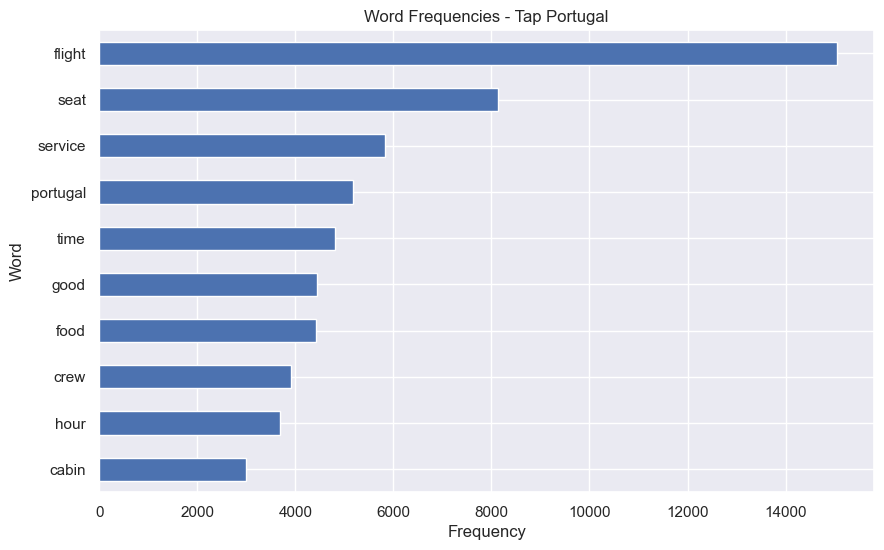

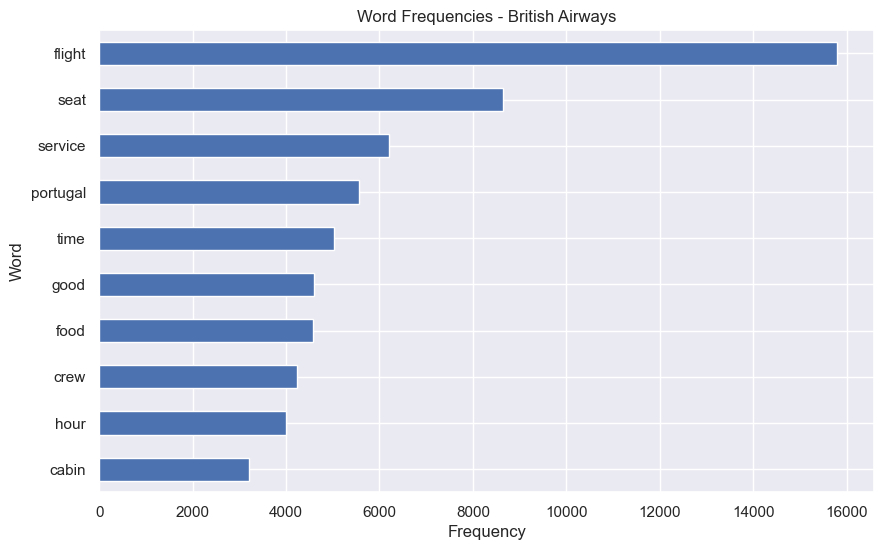

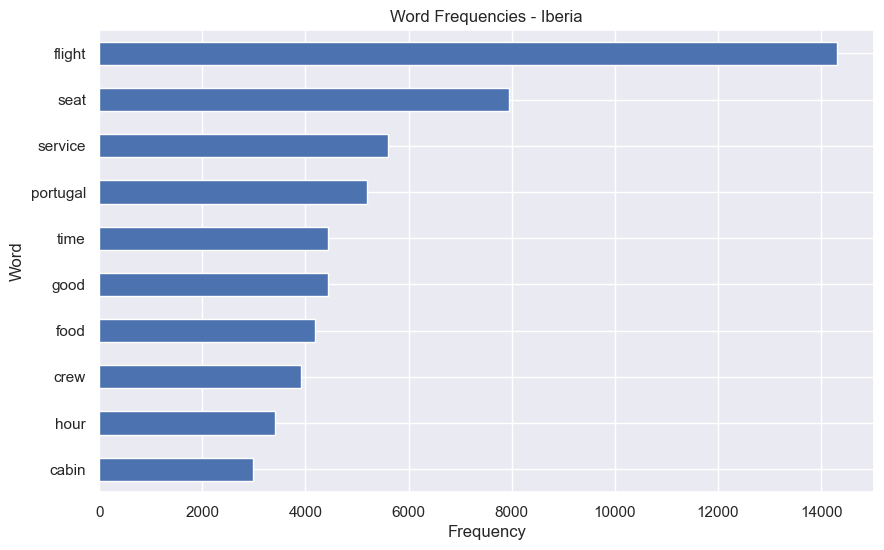

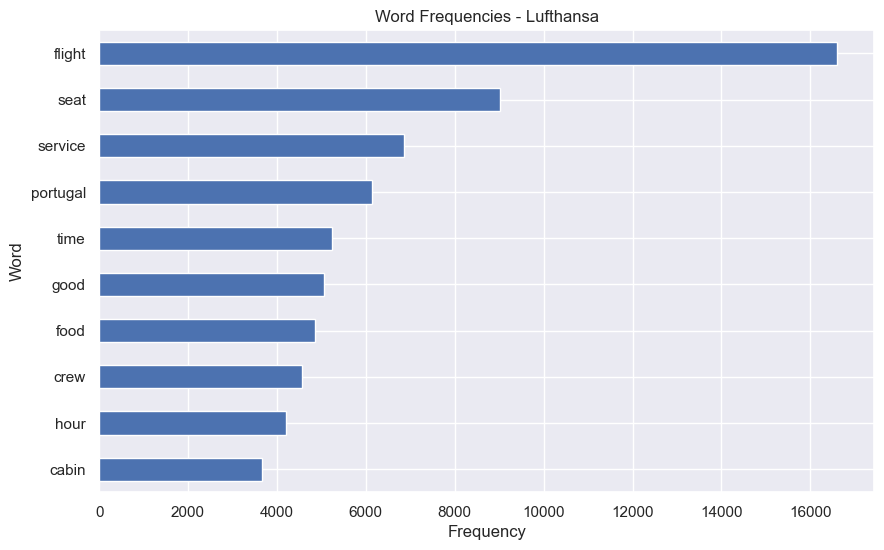

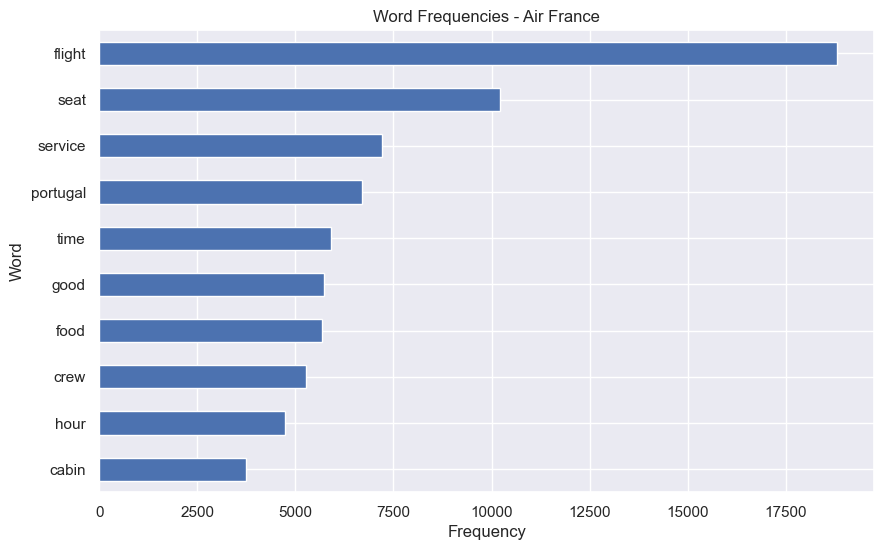

In [25]:
import matplotlib.pyplot as plt
# Plot for Tap Portugal
tap_sorted = fq_word_reviews['Tap Portugal'].sort_values(ascending=True)
tap_sorted.plot(kind='barh', figsize=(10, 6))
plt.title('Word Frequencies - Tap Portugal')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

# Plot for British Airways
british_sorted = fq_word_reviews['British Airways'].sort_values(ascending=True)
british_sorted.plot(kind='barh', figsize=(10, 6))
plt.title('Word Frequencies - British Airways')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

import matplotlib.pyplot as plt
# Plot for Iberia
tap_sorted = fq_word_reviews['Iberia'].sort_values(ascending=True)
tap_sorted.plot(kind='barh', figsize=(10, 6))
plt.title('Word Frequencies - Iberia')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

# Plot for Lufthansa
british_sorted = fq_word_reviews['Lufthansa'].sort_values(ascending=True)
british_sorted.plot(kind='barh', figsize=(10, 6))
plt.title('Word Frequencies - Lufthansa')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

# Plot for Air France
british_sorted = fq_word_reviews['Air France'].sort_values(ascending=True)
british_sorted.plot(kind='barh', figsize=(10, 6))
plt.title('Word Frequencies - Air France')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

# Sentiment Analysis

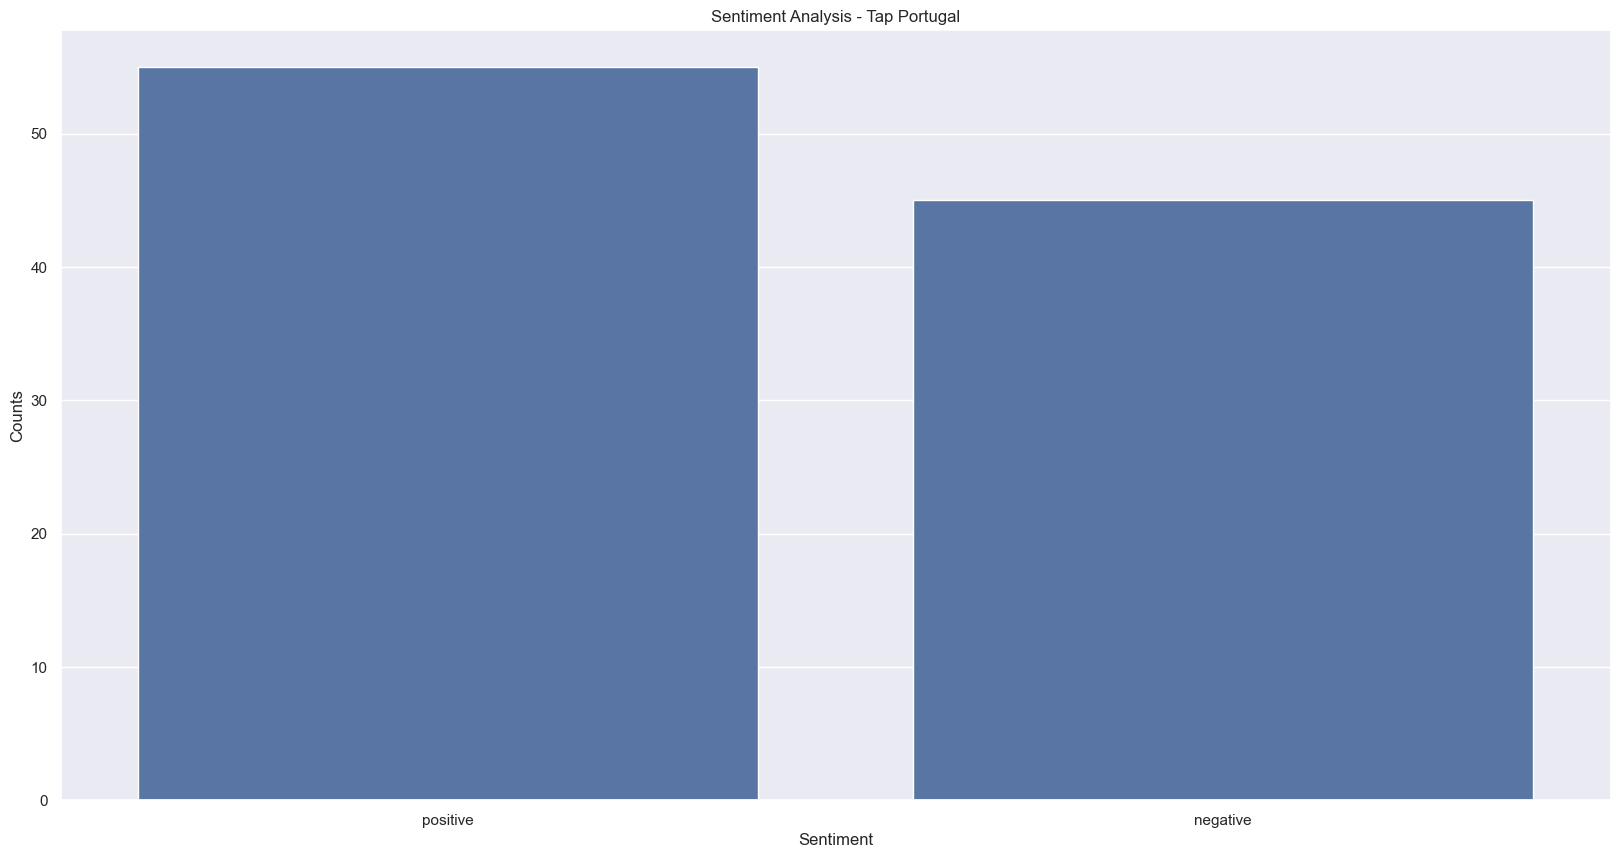

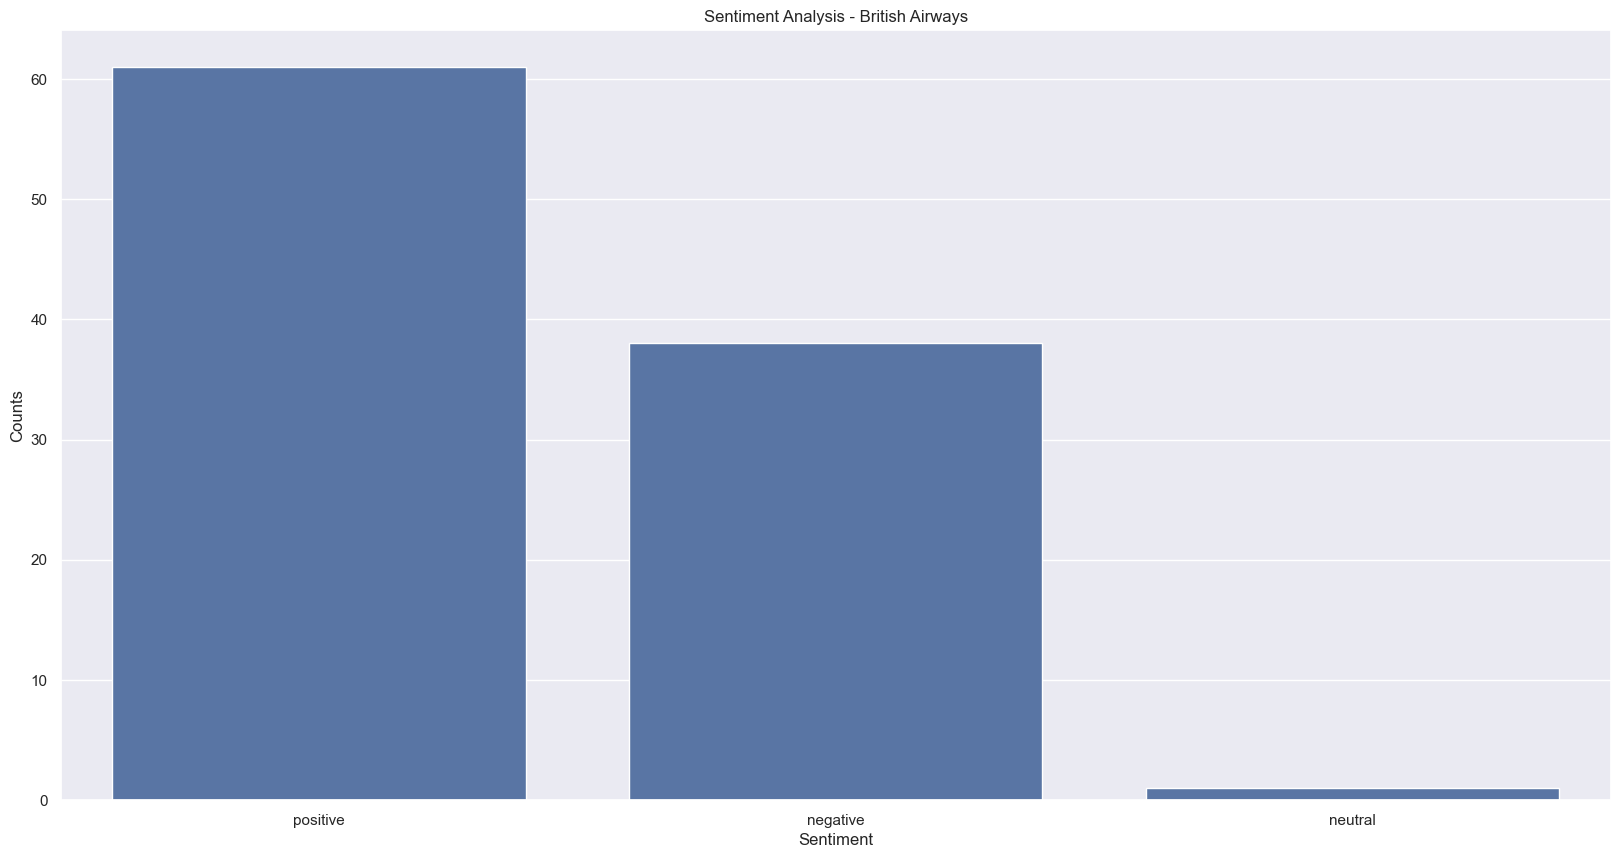

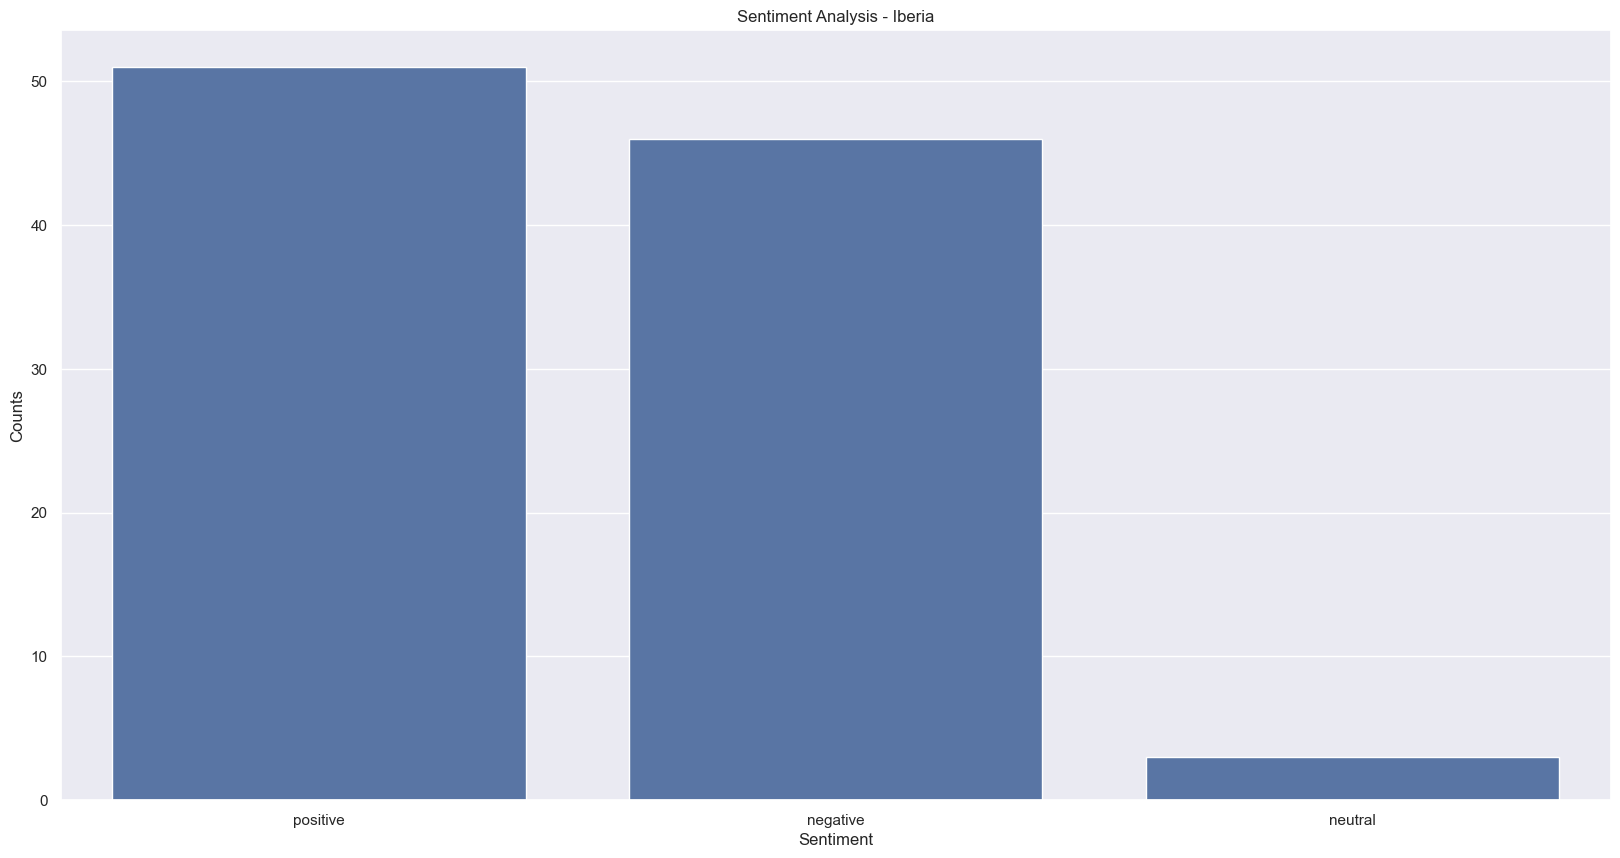

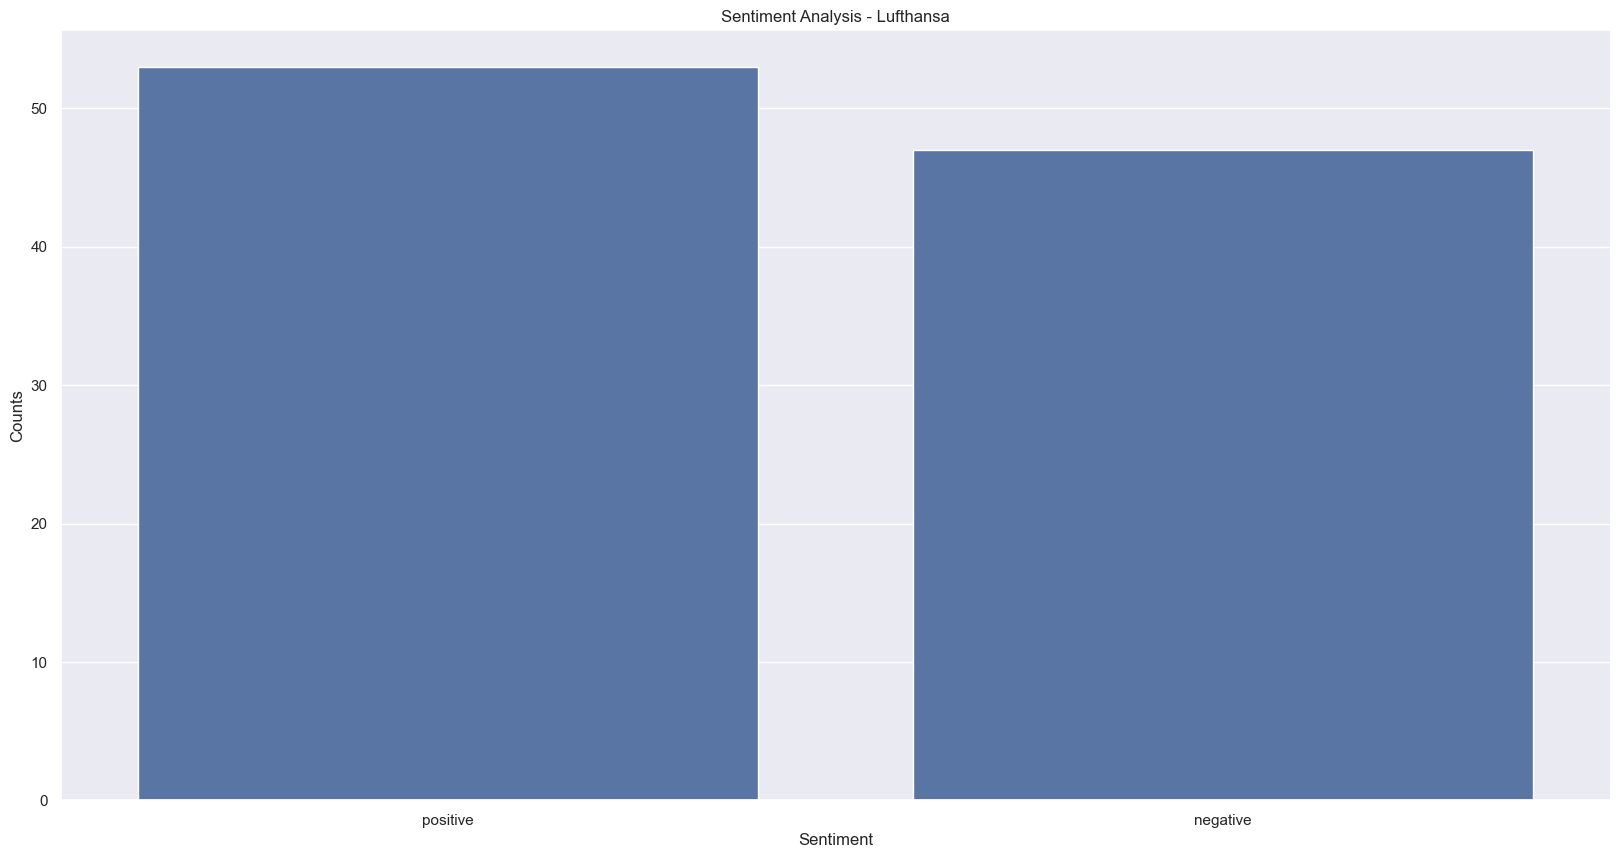

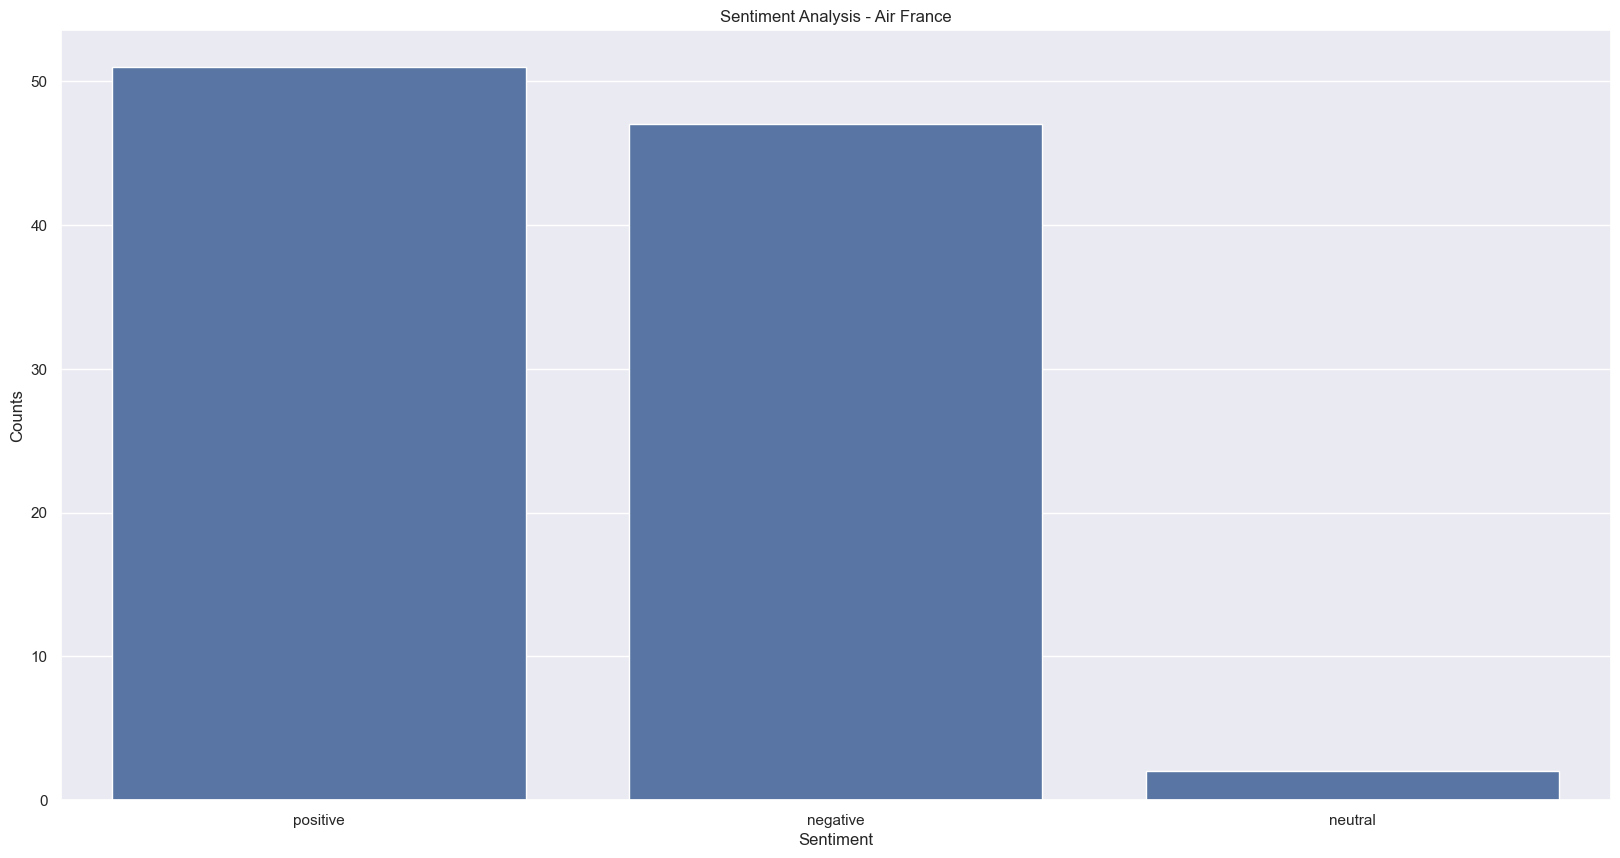

In [26]:
# Perform sentiment analysis and add 'sentiment' column to the dataframe

# Tap Portugal
tap_sentiment = df[df['Airline'] == 'Tap Portugal']['sentiment'].value_counts()
plt.figure(figsize=(8, 8))
sns.barplot(x=tap_sentiment.index, y=tap_sentiment.values)
plt.xlabel('Sentiment')
plt.ylabel('Counts')
plt.title('Sentiment Analysis - Tap Portugal')
plt.show()

# British Airways
british_sentiment = df[df['Airline'] == 'British Airways']['sentiment'].value_counts()
plt.figure(figsize=(20, 10))
sns.barplot(x=british_sentiment.index, y=british_sentiment.values)
plt.xlabel('Sentiment')
plt.ylabel('Counts')
plt.title('Sentiment Analysis - British Airways')
plt.show()

# Iberia
iberia_sentiment = df[df['Airline'] == 'Iberia']['sentiment'].value_counts()
plt.figure(figsize=(20, 10))
sns.barplot(x=iberia_sentiment.index, y=iberia_sentiment.values)
plt.xlabel('Sentiment')
plt.ylabel('Counts')
plt.title('Sentiment Analysis - Iberia')
plt.show()

# Lufthansa
lufthansa_sentiment = df[df['Airline'] == 'Lufthansa']['sentiment'].value_counts()
plt.figure(figsize=(20, 10))
sns.barplot(x=lufthansa_sentiment.index, y=lufthansa_sentiment.values)
plt.xlabel('Sentiment')
plt.ylabel('Counts')
plt.title('Sentiment Analysis - Lufthansa')
plt.show()

# Air France
france_sentiment = df[df['Airline'] == 'Air France']['sentiment'].value_counts()
plt.figure(figsize=(20, 10))
sns.barplot(x=france_sentiment.index, y=france_sentiment.values)
plt.xlabel('Sentiment')
plt.ylabel('Counts')
plt.title('Sentiment Analysis - Air France')
plt.show()

In [27]:
# Calculate sentiment percentages for Tap Portugal
tap_sentiment_percentages = df[df['Airline'] == 'Tap Portugal']['sentiment'].value_counts(normalize=True) * 100

# Calculate sentiment percentages for British Airways
ba_sentiment_percentages = df[df['Airline'] == 'British Airways']['sentiment'].value_counts(normalize=True) * 100

# Calculate sentiment percentages for Tap Portugal
iberia_sentiment_percentages = df[df['Airline'] == 'Iberia']['sentiment'].value_counts(normalize=True) * 100

# Calculate sentiment percentages for British Airways
lufth_sentiment_percentages = df[df['Airline'] == 'Lufthansa']['sentiment'].value_counts(normalize=True) * 100

# Calculate sentiment percentages for British Airways
france_sentiment_percentages = df[df['Airline'] == 'Air France']['sentiment'].value_counts(normalize=True) * 100

print("Sentiment percentages for Tap Portugal:")
print(tap_sentiment_percentages)
print()

print("Sentiment percentages for British Airways:")
print(ba_sentiment_percentages)

print("Sentiment percentages for Iberia:")
print(iberia_sentiment_percentages)
print()

print("Sentiment percentages for Lufthansa:")
print(lufth_sentiment_percentages)

print("Sentiment percentages for Air France:")
print(france_sentiment_percentages)

Sentiment percentages for Tap Portugal:
sentiment
positive    55.0
negative    45.0
Name: proportion, dtype: float64

Sentiment percentages for British Airways:
sentiment
positive    61.0
negative    38.0
neutral      1.0
Name: proportion, dtype: float64
Sentiment percentages for Iberia:
sentiment
positive    51.0
negative    46.0
neutral      3.0
Name: proportion, dtype: float64

Sentiment percentages for Lufthansa:
sentiment
positive    53.0
negative    47.0
Name: proportion, dtype: float64
Sentiment percentages for Air France:
sentiment
positive    51.0
negative    47.0
neutral      2.0
Name: proportion, dtype: float64


In [28]:
# Calculate sentiment percentages for Tap Portugal
tap_sentiment_percentages = (df[df['Airline'] == 'Tap Portugal']['sentiment'].value_counts(normalize=True) * 100).astype(int)

# Calculate sentiment percentages for British Airways
ba_sentiment_percentages = (df[df['Airline'] == 'British Airways']['sentiment'].value_counts(normalize=True) * 100).astype(int)

# Calculate sentiment percentages for Tap Portugal
iberia_sentiment_percentages = (df[df['Airline'] == 'Iberia']['sentiment'].value_counts(normalize=True) * 100).astype(int)

# Calculate sentiment percentages for British Airways
lufth_sentiment_percentages = (df[df['Airline'] == 'Lufthansa']['sentiment'].value_counts(normalize=True) * 100).astype(int)

# Calculate sentiment percentages for British Airways
france_sentiment_percentages = (df[df['Airline'] == 'Air France']['sentiment'].value_counts(normalize=True) * 100).astype(int)

print("Sentiment percentages for Tap Portugal:")
print(tap_sentiment_percentages)
print()

print("Sentiment percentages for British Airways:")
print(ba_sentiment_percentages)

print("Sentiment percentages for Iberia:")
print(iberia_sentiment_percentages)
print()

print("Sentiment percentages for Lufthansa:")
print(lufth_sentiment_percentages)

print("Sentiment percentages for Air France:")
print(france_sentiment_percentages)

Sentiment percentages for Tap Portugal:
sentiment
positive    55
negative    45
Name: proportion, dtype: int64

Sentiment percentages for British Airways:
sentiment
positive    61
negative    38
neutral      1
Name: proportion, dtype: int64
Sentiment percentages for Iberia:
sentiment
positive    51
negative    46
neutral      3
Name: proportion, dtype: int64

Sentiment percentages for Lufthansa:
sentiment
positive    53
negative    47
Name: proportion, dtype: int64
Sentiment percentages for Air France:
sentiment
positive    51
negative    47
neutral      2
Name: proportion, dtype: int64


# Airline Rating Analysis

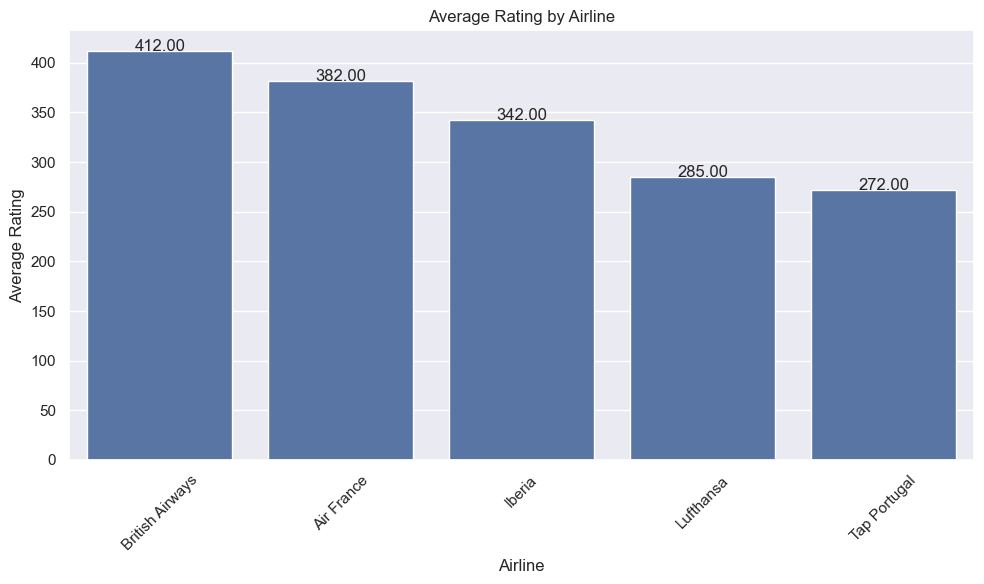

In [29]:
# Clean the Rating column and convert to numeric
df['Rating'] = df['Rating'].apply(lambda x: re.sub('[^0-9.]', '', str(x))).astype(float)

# Calculate average rating for each airline
average_rating = df.groupby('Airline')['Rating'].mean().sort_values(ascending=False)

# Plot average rating for each airline
plt.figure(figsize=(10, 6))  # Adjusted figure size
ax = sns.barplot(x=average_rating.index, y=average_rating.values)
plt.xlabel('Airline')
plt.ylabel('Average Rating')
plt.title('Average Rating by Airline')
plt.xticks(rotation=45)

# Add average rating figures on top of each bar
ax = plt.gca()  # Get current axes
for i, v in enumerate(average_rating.values):
    ax.text(i, v + 0.1, f'{v:.2f}', ha='center')

plt.tight_layout()  # Ensures labels are fully displayed
plt.show()